# Background

The fishing industry uses numerous measurements to describe a specific fish.  Our goal is to predict the weight of a fish based on a number of these measurements and determine if any of these measurements are insignificant in determining the weigh of a product.  See below for the description of these measurments.  

## Data Description

The data consists of the following variables:

1. **Weight**: weight of fish in g (numerical)
2. **Species**: species name of fish (categorical)
3. **Body.Height**: height of body of fish in cm (numerical)
4. **Total.Length**: length of fish from mouth to tail in cm (numerical)
5. **Diagonal.Length**: length of diagonal of main body of fish in cm (numerical)
6. **Height**: height of head of fish in cm (numerical)
7. **Width**: width of head of fish in cm (numerical)

In [232]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy import stats
import pylab

## Read the data

In [205]:
fishfull = pd.read_csv("Fish.csv", encoding="utf8").rename(
    columns={
        "Body Height": "BodyHeight",
        "Total Length": "TotalLength",
        "Diagonal Length": "DiagonalLength",
    }
)
rows = len(fishfull.index)
fishfull["Species"] = fishfull["Species"].astype("category")
# Split the data into training and testing sets
fishtest = fishfull.iloc[(rows - 10) :, :]
fish = fishfull.iloc[: (rows - 10), :]


# Exploratory Data Analysis

**Create a box plot comparing the response variable, *Weight*, across the multiple *species*.**

<AxesSubplot: title={'center': 'Weight'}, xlabel='[Species]'>

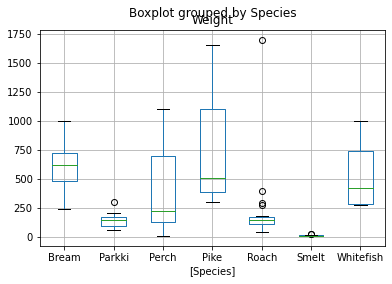

In [206]:
fish[["Species", "Weight"]].boxplot(by="Species")

It appears that the mean weight varies between different species of fish. The Bream, Pike, and Whitefish mean weights are close as are Parkki and Roach. There is also an overlap in the ranges of weight for the species so additional predictor variables will likely be needed.

**Create scatterplots of the response, *Weight*, against each quantitative predictor, namely **Body Height**, **Total Length**, **Diagonal Length**, **Height**, and **Width**.

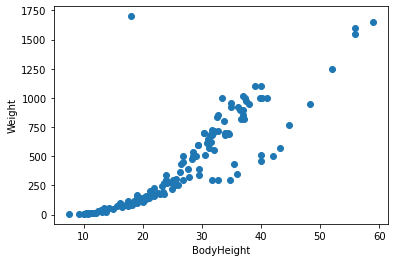

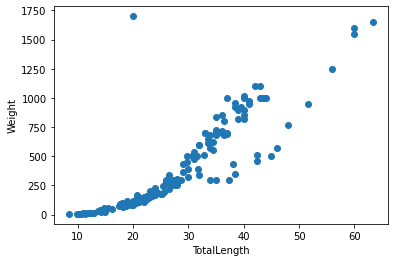

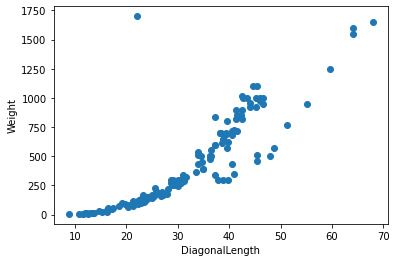

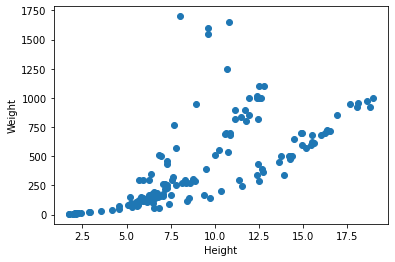

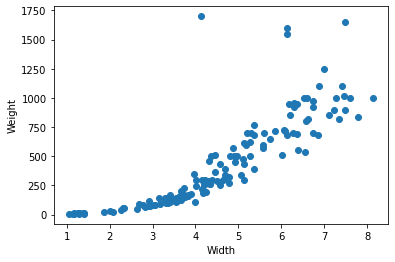

In [207]:
for x_variable in ("BodyHeight", "TotalLength", "DiagonalLength", "Height", "Width"):
    plt.scatter(fish[x_variable], fish["Weight"])
    plt.xlabel(x_variable)
    plt.ylabel("Weight")
    plt.show()

The general trend is a slightly upward curved line that starts to deviate into another curved line for **Body Height**, **Total Length**, **Diagonal Length**, and **Height**. **Width** has the same general curve as the other predictors but not as much of a deviation. It appears that all of the predictors have strong positive correlation. The relationships do appear to be non-linear. **Body Height**, **Total Length**, **Diagonal Length** look very similar suggesting that they may be highly correlated.

There does appear to be some outliers shown by the deviation from the general trend.

**Display the correlations between each of the quantitative variables.**

                  Weight  BodyHeight  TotalLength  DiagonalLength    Height  \
Weight          1.000000    0.861689     0.865477        0.868825  0.687980   
BodyHeight      0.861689    1.000000     0.999513        0.991950  0.626860   
TotalLength     0.865477    0.999513     1.000000        0.994090  0.642226   
DiagonalLength  0.868825    0.991950     0.994090        1.000000  0.705212   
Height          0.687980    0.626860     0.642226        0.705212  1.000000   
Width           0.845672    0.866188     0.872803        0.877036  0.790849   

                   Width  
Weight          0.845672  
BodyHeight      0.866188  
TotalLength     0.872803  
DiagonalLength  0.877036  
Height          0.790849  
Width           1.000000  


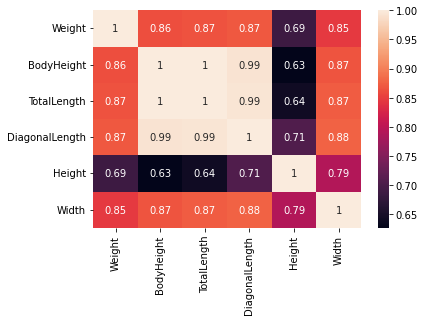

In [208]:
print(fish.corr())
sns.heatmap(fish.corr(), annot=True)
plt.show()

There is a strong positive correlation between **Body Height**, **Total Length**, and **Width** with a fairly strong positive correlation with Height. All of the predictors are positively correlated.

Further analysis should be done on the outliers and possible transformations but otherwise starting with a multiple linear regression is a good model to begin with. There is heavy correlation between the quantitative variables but with the qualitative Species variable this may not be a significant issue. Also with the goal of predicting the Weight the multicollinearity is not a big issue.

# Fitting the Multiple Linear Regression Model

**Build a multiple linear regression model, using the response and all predictors.**

In [209]:
model1 = ols(
    "Weight ~ Species + BodyHeight + TotalLength + DiagonalLength + Height + Width",
    data=fish,
).fit()
print(model1.summary())

                            OLS Regression Results                            
Dep. Variable:                 Weight   R-squared:                       0.842
Model:                            OLS   Adj. R-squared:                  0.829
Method:                 Least Squares   F-statistic:                     66.30
Date:                Sun, 01 Jan 2023   Prob (F-statistic):           2.65e-49
Time:                        21:56:20   Log-Likelihood:                -957.74
No. Observations:                 149   AIC:                             1939.
Df Residuals:                     137   BIC:                             1976.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept             -813.8993 

The overall p-value is < 2.2e-16 indicating the overall regression is less than an $\alpha$ level of 0.01.

# Checking for Outliers and Multicollinearity

**(a) Create a plot for the Cook's Distances.**

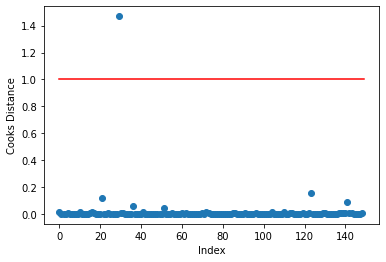

Observation 29 is a possible outlier with a Cook's distance greater than 1


In [210]:
influence = model1.get_influence()
cooks_distance = influence.cooks_distance

plt.scatter(fish.index, cooks_distance[0])
plt.plot([0, len(fish.index)], [1, 1], color="red")
plt.xlabel("Index")
plt.ylabel("Cooks Distance")
plt.show()
print(
    f"Observation {np.where(cooks_distance[0] >= 1)[0][0]} is a possible outlier with a Cook's distance greater than 1"
)


**(b) Remove the outlier(s) from the data set and create a new model.**

In [211]:
fish_outlier_removed = fish.drop([np.where(cooks_distance[0] >= 1)[0][0]])

model2 = ols(
    "Weight ~ Species + BodyHeight + TotalLength + DiagonalLength + Height + Width",
    data=fish_outlier_removed,
).fit()
print(model2.summary())

                            OLS Regression Results                            
Dep. Variable:                 Weight   R-squared:                       0.938
Model:                            OLS   Adj. R-squared:                  0.934
Method:                 Least Squares   F-statistic:                     188.6
Date:                Sun, 01 Jan 2023   Prob (F-statistic):           1.36e-76
Time:                        21:56:21   Log-Likelihood:                -875.90
No. Observations:                 148   AIC:                             1776.
Df Residuals:                     136   BIC:                             1812.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept             -969.7659 

**(c) Display the VIF of each predictor for model2, using a VIF threshold of $max(10, \frac{1}{(1-R^2)})$ what conclusions can you draw?**

In [228]:
print(f"VIF Threshold: {max(10, 1/(1-model2.rsquared))}")
model2_data = pd.get_dummies(fish_outlier_removed)
model2_vif = pd.DataFrame()
model2_vif["VIF"] = [
    variance_inflation_factor(model2_data.values, i)
    for i in range(len(model2_data.columns))
]
model2_vif["variable"] = model2_data.columns
print(model2_vif)

VIF Threshold: 16.255834320951717
            VIF           variable
0     16.255834             Weight
1   2443.616275         BodyHeight
2   4620.531611        TotalLength
3   2146.458993     DiagonalLength
4     56.444052             Height
5     29.041582              Width
6     93.563546      Species_Bream
7      9.333485     Species_Parkki
8     37.597980      Species_Perch
9     33.681572       Species_Pike
10    17.899067      Species_Roach
11     4.644112      Species_Smelt
12     6.875754  Species_Whitefish


VIFs of BodyHeight, TotalLength, DiagonalLength, Height, and Width are all greater than $max(10, \frac{1}{(1-R^2)})$ indicating there is a problem of multicollinearity in the model.


# Checking Model Assumptions

**(a) Create scatterplots of the standardized residuals of model2 versus each quantitative predictor. Does the linearity assumption appear to hold for all predictors?**

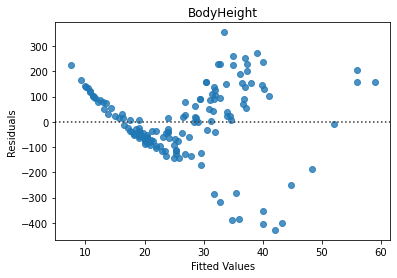

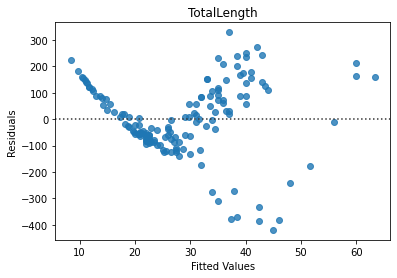

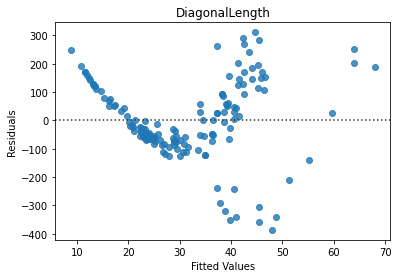

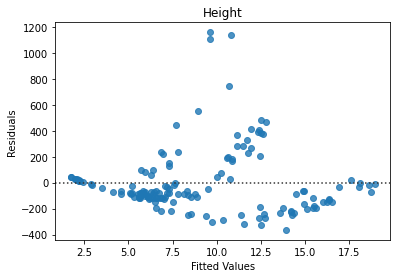

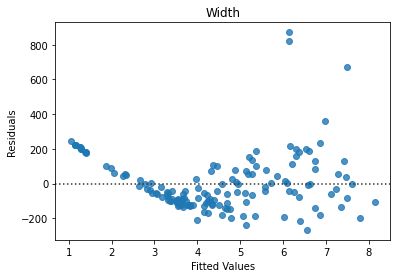

In [213]:
for x_variable in ("BodyHeight", "TotalLength", "DiagonalLength", "Height", "Width"):
    ax = sns.residplot(x=x_variable, y="Weight", data=fish_outlier_removed)
    ax.set(xlabel="Fitted Values", ylabel="Residuals", title=x_variable)
    plt.show()

The residuals don’t seem to vary with any of the predicting variables but there does seem to be some clustering.The linearity assumption does not appear to hold up.

**(b) Create a scatter plot of the standardized residuals of model2 versus the fitted values of model2.  Does the constant variance assumption appear to hold?  Do the errors appear uncorrelated?**

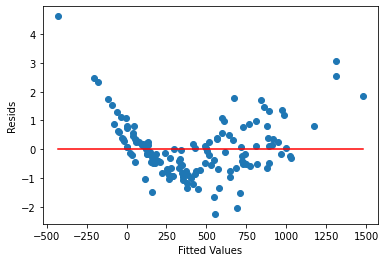

In [214]:
plt.scatter(model2.fittedvalues, model2.resid_pearson)
plt.xlabel("Fitted Values")
plt.ylabel("Resids")
plt.plot(
    [np.min(model2.fittedvalues), np.max(model2.fittedvalues)], [0, 0], color="red"
)

The constant variance does not hold, the variance starts positive, decreases in the middle range, and then increases again. There errors may be correlated as they have a particular trend in different regions of the fitted values.

**(c) Create a histogram and normal QQ plot for the standardized residuals.**

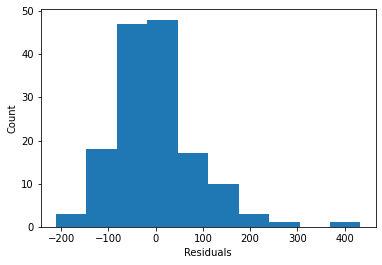

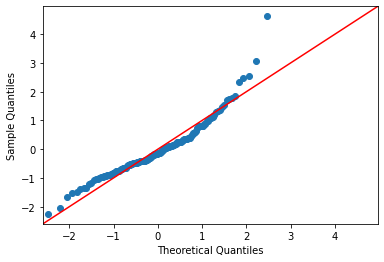

In [215]:
plt.hist(model2.resid)
plt.xlabel("Residuals")
plt.ylabel("Count")

sm.qqplot(model2.resid_pearson, line="45")
pylab.show()

The histogram and qq plot check for normality. It does not appear that the data is normal as it extends to each end.

# Partial F Test

**(a) Build a third multiple linear regression model using the cleaned data set without the outlier(s), called model3, using only *Species* and *TotalLength* as predicting variables and *Weight* as the response.**

In [216]:
model3 = ols("Weight ~ Species + TotalLength", data=fish_outlier_removed).fit()
print(model3.summary())

                            OLS Regression Results                            
Dep. Variable:                 Weight   R-squared:                       0.935
Model:                            OLS   Adj. R-squared:                  0.932
Method:                 Least Squares   F-statistic:                     289.1
Date:                Sun, 01 Jan 2023   Prob (F-statistic):           6.49e-80
Time:                        21:56:33   Log-Likelihood:                -879.64
No. Observations:                 148   AIC:                             1775.
Df Residuals:                     140   BIC:                             1799.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept             -730.9770 

**(b) Conduct a partial F-test comparing model3 with model2.**

In [217]:
aov = sm.stats.anova_lm(model3, model2, typ=1)
aov

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,140.0,1.259746e+06,0.0,NaN,NaN,NaN
1,136.0,1.197659e+06,4.0,62086.6613,1.762561,0.139974


Comparing model3 to model2 the p-value is 0.14. At an $\alpha$ level of 0.01 the null hypothesis is accepted and none of BodyHeight, DiagonalLength, Height, or Width improve the explanatory power of the model.

# Reduced Model Residual Analysis and Multicollinearity Test

**(a) Conduct a multicollinearity test on model3.**

In [226]:
print(f"VIF Threshold: {max(10, 1/(1-model3.rsquared))}")
model3_data = pd.get_dummies(fish_outlier_removed[["Species", "TotalLength"]])
model3_vif = pd.DataFrame()
model3_vif["VIF"] = [
    variance_inflation_factor(model3_data.values, i)
    for i in range(len(model3_data.columns))
]
model3_vif["variable"] = model3_data.columns
print(model3_vif)

VIF Threshold: 15.454664277991043
        VIF           variable
0  2.654472        TotalLength
1  6.808601      Species_Bream
2  1.550565     Species_Parkki
3  7.399797      Species_Perch
4  6.032822       Species_Pike
5  2.452740      Species_Roach
6  1.286072      Species_Smelt
7  1.912050  Species_Whitefish


Neither predictor is greater than $max(10, \frac{1}{(1-R^2)})$ which is an indication that there is no multicollinearity issue in model3.

**(b) Conduct residual analysis for model3.**

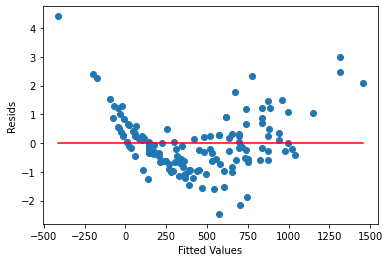

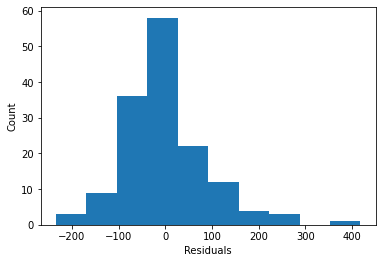

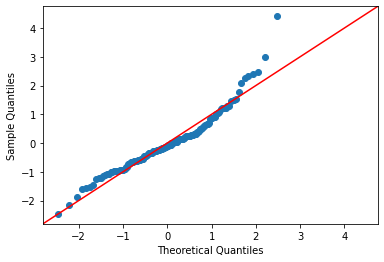

In [231]:
plt.scatter(model3.fittedvalues, model3.resid_pearson)
plt.xlabel("Fitted Values")
plt.ylabel("Resids")
plt.plot(
    [np.min(model3.fittedvalues), np.max(model3.fittedvalues)], [0, 0], color="red"
)

pylab.show()
plt.hist(model3.resid)
plt.xlabel("Residuals")
plt.ylabel("Count")

sm.qqplot(model3.resid_pearson, line="45")
pylab.show()

The Standard Residuals plot is very similar to the same model2 plot with some slight improvements. The Scatter Plot of fitted values and Standard Residuals looks very similar between models.The histogram and qqNorm only show slight improvements as well. There is not enough improvement to confirm that model3 holds the assumptions better than model2.

# Transformation

**(a) Find the optimal lambda of model3 for a Box-Cox transformation on model3.**

In [238]:
y_fitted, best_lambda = stats.boxcox(fish_outlier_removed["Weight"])
best_lambda

0.33274403753458714

The value of $\lambda$ is 0.34 but rounding to the nearest 0.5 rounds up to a $\lambda$ value of 0.5. With a $\lambda$ value of 0.5 the transformation that should be used is $\sqrt y$.

**(b) Create model4 with the $\sqrt y$ transformation.**

In [240]:
sqrt_transformed_data = fish_outlier_removed.copy()
sqrt_transformed_data["Weight"] = np.sqrt(sqrt_transformed_data["Weight"])

model4 = ols("Weight ~ Species+TotalLength", data=sqrt_transformed_data).fit()
print(model4.summary())

                            OLS Regression Results                            
Dep. Variable:                 Weight   R-squared:                       0.982
Model:                            OLS   Adj. R-squared:                  0.981
Method:                 Least Squares   F-statistic:                     1074.
Date:                Mon, 02 Jan 2023   Prob (F-statistic):          2.80e-118
Time:                        21:35:49   Log-Likelihood:                -242.42
No. Observations:                 148   AIC:                             500.8
Df Residuals:                     140   BIC:                             524.8
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -6.9665 

**(c) Perform Residual Analysis on model4.**

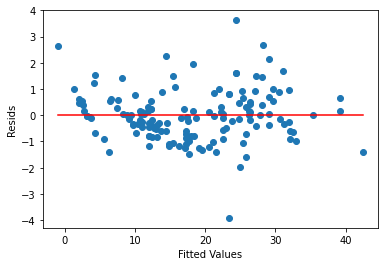

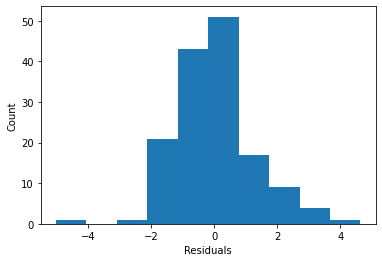

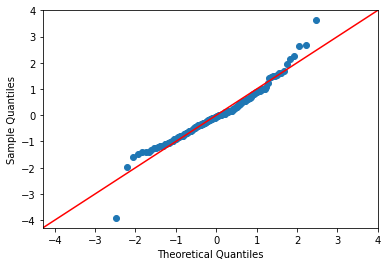

In [241]:
plt.scatter(model4.fittedvalues, model4.resid_pearson)
plt.xlabel("Fitted Values")
plt.ylabel("Resids")
plt.plot(
    [np.min(model4.fittedvalues), np.max(model4.fittedvalues)], [0, 0], color="red"
)

pylab.show()
plt.hist(model4.resid)
plt.xlabel("Residuals")
plt.ylabel("Count")

sm.qqplot(model4.resid_pearson, line="45")
pylab.show()

The linearity and constant variance assumptions look much better after transforming the response. The distribution of the residuals is still a bit heavy-tailed but is much improved after the transformation. Overall the linearity, constant variance, and normality assumptions look much better. I would consider the transformation successful.

# Model Comparison

**(a) Using each model summary, compare and discuss the R-squared and Adjusted R-squared of model2, model3, and model4.**



In [255]:
print(model2.rsquared, model2.rsquared_adj)
model_comparison = pd.DataFrame(
    data={
        "R Squared": [model2.rsquared, model3.rsquared, model4.rsquared],
        "Ajusted R Squared": [
            model2.rsquared_adj,
            model3.rsquared_adj,
            model4.rsquared_adj,
        ],
    },
    index=["Model2", "Model3", "Model4"],
)
model_comparison

0.9384836250015709 0.9335080358472863


,R Squared,Ajusted R Squared
Model2,0.938484,0.933508
Model3,0.935295,0.932059
Model4,0.981714,0.980800


All 3 models explain the variance well. Model 3 actually decreases the $R^2$ and Adjusted $R^2$ values. Model 4 has the highest $R^2$ and Adjusted $R^2$ values.

# Prediction

**(a) Predict Weights for the last 10 rows of data (fishtest) using both model3 and model4.**

In [261]:
model3_prediction = model3.get_prediction(exog=fishtest).summary_frame(alpha=0.05)
model3_prediction

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,835.320989,18.339959,799.061904,871.580074,644.307134,1026.334844
1,492.283575,16.701313,459.264181,525.302968,301.858125,682.709024
2,351.535704,32.195485,287.883501,415.187906,153.487290,549.584118
3,7.581312,17.272839,-26.568019,41.730644,-183.043314,198.205939
4,223.690686,14.049796,195.913485,251.467887,34.103914,413.277459
5,-143.287496,20.378198,-183.576288,-102.998704,-335.107094,48.532102
6,185.102637,29.701132,126.381903,243.823371,-11.416309,381.621583
7,621.398920,24.844012,572.280974,670.516865,427.532615,815.265224
8,147.658936,31.619977,85.144543,210.173329,-50.026725,345.344598
9,14.734838,26.309275,-37.280011,66.749687,-179.885603,209.355278


In [263]:
# Need to undo square root transformation
model4_prediction = np.square(
    model4.get_prediction(exog=fishtest).summary_frame(alpha=0.05)
)
model4_prediction

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,792.226518,0.061242,764.923852,820.007938,653.777504,943.961982
1,464.365899,0.050787,445.362083,483.766739,360.226919,581.709600
2,270.026750,0.188729,242.537006,298.991882,189.341021,364.995564
3,78.338451,0.054322,70.393897,86.707666,39.422169,130.487091
4,192.895243,0.035941,182.624454,203.447001,128.379867,270.499284
5,28.451192,0.075610,22.947252,34.546214,7.538583,62.762580
6,164.620562,0.160618,144.916002,185.580755,103.606463,239.697990
7,529.048346,0.112381,498.998662,559.976566,415.552950,656.229975
8,136.419492,0.182042,117.426211,156.835886,81.223425,205.846369
9,11.490715,0.126028,7.224985,16.741666,0.583214,36.191133


In [281]:
np.mean(
    np.power(
        model3_prediction["mean"].reset_index(drop=True)
        - fishtest["Weight"].reset_index(drop=True),
        2,
    )
)


9392.24969170129

In [282]:
np.mean(
    np.power(
        model4_prediction["mean"].reset_index(drop=True)
        - fishtest["Weight"].reset_index(drop=True),
        2,
    )
)


2442.997746126825

The Mean Square Prediction Error for model3 is 9392 compared to model4 MSPE of 2443. This shows that model4 has less of an error when predicting the Weight of the fish. Additional testing should be done before accepting this conclusion but this calculation indicates that model4 is the better model.

**(b) Suppose you have found a Perch fish with a BodyHeight of 28 cm, and a TotalLength of 32 cm. Using model4, predict the weight on this fish with a 90% prediction interval**

In [288]:
test_perch = pd.DataFrame(
    data={"Species": "Perch", "BodyHeight": 28, "TotalLength": 32}, index=[0]
)
perch_prediction = np.square(
    model4.get_prediction(exog=test_perch).summary_frame(alpha=0.10)
)
perch_prediction

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,461.942923,0.035214,448.682922,475.396019,374.453567,558.609077


The predicted weight of the Perch is 461.9 g with a lower range of 374 g and and upper range of 559 g. Base on these results there is a 90% chance that the actual weight falls between 374 g and 559 g.